# Etude de cas : analyse des fichiers de logs des cyclistes

Objectif: A partir des fichiers contenu dans le dossier ./data/Cyclistes, calculer la durée de chacun des trajets effectués par chaque cycliste.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import udf
from pyspark.sql.window import Window

## 1)  Charger la donnée
Créez une seesion Spark et chargez les données Cyclistes.

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
cyclistes = spark.read.load("./data/Cyclistes/", format="csv", header=True, inferSchema="True")
cyclistes.dtypes

[('id', 'int'),
 ('timestamp', 'timestamp'),
 ('sur_velo', 'boolean'),
 ('velo', 'string'),
 ('vitesse', 'double'),
 ('position', 'string'),
 ('destination_finale', 'string')]

## 2) Vérifier le nombre de cyclistes

Comptez le nombre d'id uniques.

In [4]:
cyclistes.distinct().count()

2232000

## 3) Transformer la colonne timestamp

Lorsqu'on vérifie le type de donnée de la colonne timestamp, on voit qu'on a une chaîne de caractères. Pour calculer une durée on voudrait transformer en date exploitable en tant que telle.
A l'aide d'une fonction udf, créez une nouvelle colonne date qui contiendra le résultat de la transformation des chaînes de caractères de la colonne timestamp en véritables timestamps.

In [7]:
cyclistes.show(10)

+---+-------------------+--------+-----+--------------------+-------------------+------------------+
| id|          timestamp|sur_velo| velo|             vitesse|           position|destination_finale|
+---+-------------------+--------+-----+--------------------+-------------------+------------------+
| 12|2018-01-01 00:01:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:02:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:03:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:04:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:05:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:06:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:07:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|          

In [ ]:
# Mon tableau était déja en timestamps mais si il faut convertir il aurait fallu :

# dfModifie = cyclistes.withColumn("timestamp",to_timestamp("timestamp", format='yyyy-MM-dd HH:mm:ss'))
# cyclistes = dfModifie



## 4) Durée des trajets par id.

1) Trouvez les dates min/max par état de sur_velo, puis par id ET par état de sur_velo.

In [14]:
cyclistes.groupBy("id" ,"sur_velo").agg({"timestamp":"min"}).show(10)

+---+--------+-------------------+
| id|sur_velo|     min(timestamp)|
+---+--------+-------------------+
| 36|    true|2018-01-01 08:47:00|
| 15|    true|2018-01-01 10:19:00|
| 12|    true|2018-01-01 08:57:00|
| 12|   false|2018-01-01 00:01:00|
| 43|    true|2018-01-01 07:44:00|
| 36|   false|2018-01-01 00:01:00|
| 43|   false|2018-01-01 00:01:00|
| 15|   false|2018-01-01 00:01:00|
| 42|   false|2018-01-01 00:01:00|
| 41|   false|2018-01-01 00:01:00|
+---+--------+-------------------+
only showing top 10 rows



In [15]:
cyclistes.groupBy("id" ,"sur_velo").agg({"timestamp":"max"}).show(10)

+---+--------+-------------------+
| id|sur_velo|     max(timestamp)|
+---+--------+-------------------+
| 36|    true|2018-01-31 21:32:00|
| 15|    true|2018-01-31 20:31:00|
| 12|    true|2018-01-31 16:49:00|
| 12|   false|2018-02-01 00:00:00|
| 43|    true|2018-01-30 18:53:00|
| 36|   false|2018-02-01 00:00:00|
| 43|   false|2018-02-01 00:00:00|
| 15|   false|2018-02-01 00:00:00|
| 42|   false|2018-02-01 00:00:00|
| 41|   false|2018-02-01 00:00:00|
+---+--------+-------------------+
only showing top 10 rows



2) Le résultat n'est pas trés pertinent, il faudrait plutôt le début et la fin de chaque trajet par id. Pour cela, il faudrait détecter les changements d'état "sur_vélo".

Créez une fonction python (voir fonction udf) qui permet de detecter ces changements d'état.
Utilisez la classe Window() et la fonction F.lag() avec votre fonction udf pour créer une nouvelle colonne que vous appellerez changement, contenant un 0 si l'état précedent de sur_velo est le même et un 1 si l'état vient de changer pour chaque id.

In [81]:
@udf(returnType = IntegerType())
def check(actual, previous):
# cyclistes.filter(cyclistes.id == 14).sort(F.col("timestamp").asc()).show()
    if previous == None:
        return 0
    if previous == actual:
        return 0
    if actual != previous:
        return 1

In [83]:
w = Window.partitionBy("id").orderBy("timestamp")
cyclistes = cyclistes.withColumn("changement",check(F.lag("sur_velo",0).over(w), F.lag("sur_velo",1).over(w)))


3) Grâce à cette nouvelle colonne changement, trouvez un moyen qui permettra de numeroter les trajets pour chaque id et stockez les résulats dans une nouvelle colonne appelée numero_de_trajet.

In [107]:
# remove all sur_velo to false 
w2 = Window.partitionBy("id").orderBy("timestamp")
dfStateChanged = cyclistes.filter(cyclistes.sur_velo == 1).withColumn("numero_de_trajet", F.sum("changement").over(w2))

In [163]:
dfStateChanged.show()

+---+-------------------+--------+--------------------+-----------------+-------------------+-------------------+----------+----------------+
| id|          timestamp|sur_velo|                velo|          vitesse|           position| destination_finale|changement|numero_de_trajet|
+---+-------------------+--------+--------------------+-----------------+-------------------+-------------------+----------+----------------+
|  2|2018-01-01 12:33:00|    true|velo_velo_162_per...|5.313536596841792|(lon:3.00 lat:3.00)|(lon:2.34 lat:0.97)|         1|               1|
|  2|2018-01-01 12:34:00|    true|velo_velo_162_per...|5.313536596841792|(lon:2.00 lat:1.00)|(lon:2.34 lat:0.97)|         0|               1|
|  2|2018-01-01 12:35:00|    true|velo_velo_162_per...|5.313536596841792|(lon:2.00 lat:1.00)|(lon:2.34 lat:0.97)|         0|               1|
|  2|2018-01-01 12:36:00|    true|velo_velo_162_per...|5.313536596841792|(lon:2.00 lat:2.00)|(lon:2.34 lat:0.97)|         0|               1|
|  2|2

4) Il suffit maintenant de repêter la première étape, c'est a dire récupérer la début et la fin de chaque trajet pour chaque id, puis calculer la durée des trajets. 

(Pensez à récuperer les "vrai trajet au préalable (avec un état sur_vélo = 1).

In [204]:
dfTimer = dfStateChanged.groupBy("id" ,"numero_de_trajet").agg(F.min("timestamp").alias("start_time"),F.max("timestamp").alias("end_time"))
# dfNew = dfStateChanged.select(((F.col("end_time") - F.col("start_time"))).alias("total duration")) not working
dfTimer = dfTimer.withColumn("total_duration", (F.col("end_time").cast("long") - F.col("start_time").cast("long"))/60)
dfTimer.show()

+---+----------------+-------------------+-------------------+--------------+
| id|numero_de_trajet|         start_time|           end_time|total_duration|
+---+----------------+-------------------+-------------------+--------------+
|  2|               1|2018-01-01 12:33:00|2018-01-01 12:36:00|           3.0|
|  2|               2|2018-01-01 19:59:00|2018-01-01 20:00:00|           1.0|
|  2|               3|2018-01-02 12:33:00|2018-01-02 12:34:00|           1.0|
|  2|               4|2018-01-02 19:59:00|2018-01-02 20:00:00|           1.0|
|  2|               5|2018-01-03 12:33:00|2018-01-03 12:34:00|           1.0|
|  2|               6|2018-01-03 19:59:00|2018-01-03 20:00:00|           1.0|
|  2|               7|2018-01-04 12:33:00|2018-01-04 12:34:00|           1.0|
|  2|               8|2018-01-04 19:59:00|2018-01-04 20:00:00|           1.0|
|  2|               9|2018-01-05 12:33:00|2018-01-05 12:34:00|           1.0|
|  2|              10|2018-01-05 19:59:00|2018-01-05 20:00:00|  

## 5) Data visualisation

Convertissez votre dataframe pyspark en dataframe pandas.

In [205]:
import pyspark

pandasDF = dfTimer.toPandas()
print(pandasDF.info)

<bound method DataFrame.info of       id  numero_de_trajet          start_time            end_time  \
0      2                 1 2018-01-01 12:33:00 2018-01-01 12:36:00   
1      2                 2 2018-01-01 19:59:00 2018-01-01 20:00:00   
2      2                 3 2018-01-02 12:33:00 2018-01-02 12:34:00   
3      2                 4 2018-01-02 19:59:00 2018-01-02 20:00:00   
4      2                 5 2018-01-03 12:33:00 2018-01-03 12:34:00   
...   ..               ...                 ...                 ...   
1759  51                30 2018-01-26 16:39:00 2018-01-26 17:31:00   
1760  51                31 2018-01-29 06:29:00 2018-01-29 08:48:00   
1761  51                32 2018-01-29 17:08:00 2018-01-29 18:47:00   
1762  51                33 2018-01-30 06:29:00 2018-01-30 09:45:00   
1763  51                34 2018-01-30 13:56:00 2018-01-30 14:48:00   

      total_duration  
0                3.0  
1                1.0  
2                1.0  
3                1.0  
4           

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


1) A l'aide des librairies matplotlib et/ou seaborn, réalisez un graphique en barre montrant le temps total passé à vélo par chaque cycliste.

In [217]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

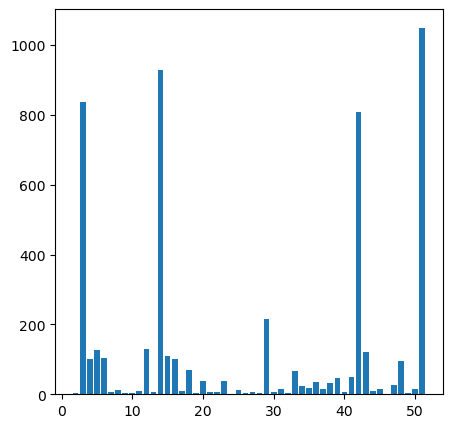

In [218]:
plt.figure(figsize=(5, 5))
plt.bar(pandasDF["id"], pandasDF["total_duration"])
plt.show()

2) Réalisez un graphique en barre qui affiche le temps de chaque trajet d'un cycliste. Faites en sorte qu'on puisse choisir un id et afficher les trajets de cet id.

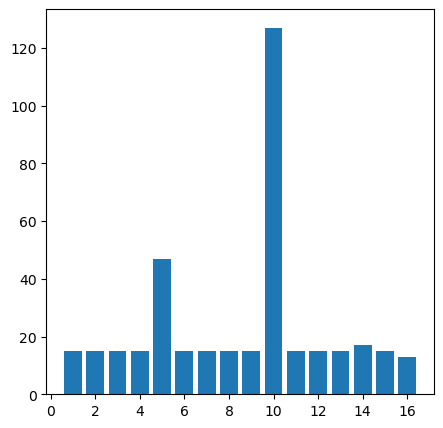

In [219]:
def getBarChartById(id):
    dfFiltById = pandasDF.where(pandasDF.id==id)
    plt.figure(figsize=(5, 5))
    plt.bar(dfFiltById["numero_de_trajet"], dfFiltById["total_duration"])
    plt.show()
    
getBarChartById(5)
    

## 6) Sauvegarde

Sauvegardez votre dataset trajets au format csv dans le dossier data.

In [220]:
pandasDF.to_csv('velo-human.csv', index = False, encoding='utf-8')